# COMPUTER VISON PROJECT - 2

## Author: Sridharan Chandran

## Part A
**• DOMAIN:** Entertainment

**• CONTEXT:** Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

**• DATA DESCRIPTION:** The dataset comprises of images and its mask for corresponding human face.

**• PROJECT OBJECTIVE:** To build a face detection system.

# Steps and tasks: 
## 1. Import and Understand the data 
### A. Import and read ‘images.npy’.
### B. Split the data into Features(X) & labels(Y). Unify shape of all the images.
Imp Note: Replace all the pixels within masked area with 1.

Hint: X will comprise of array of image whereas Y will comprise of coordinates of the mask(human face). Observe: data[0], data[0][0], data[0][1].
### C. Split the data into train and test[400:9].
### D. Select random image from the train data and display original image and masked image.

In [1]:
#Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Activation, SpatialDropout2D
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc,classification_report, roc_curve
from tensorflow.keras import optimizers
from keras import regularizers
from keras.optimizers import SGD
from tensorflow.keras import backend
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from glob import glob
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow
tensorflow.__version__

'2.12.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset

file_path = "/content/drive/My Drive/Colab Notebooks/My Python Projects/CV Project - 2 - Face Recognition/images.npy"

data = np.load(file_path, allow_pickle=True)

In [5]:
images = data[:,0]
mask = data[:,1]
print(images.shape, mask.shape)

(409,) (409,)


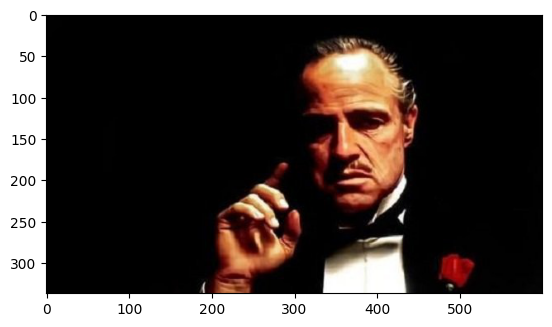

In [6]:
# Plotting few sample images to check the dataset
plt.imshow(images[10]);

In [7]:
mask[10]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

In [8]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1

In [9]:
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_t = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_t[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1
print(X_t.shape)
print(masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


In [10]:
# Split the data into Features & labels
X = X_t
Y = masks

In [11]:
# Split data into train & test set [400:9]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 9, random_state = 42)

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(400, 224, 224, 3)
(400, 224, 224)
(9, 224, 224, 3)
(9, 224, 224)


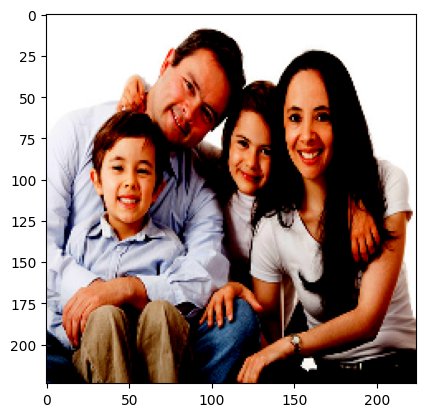

In [13]:
n = 18
plt.imshow(X_train[n]);

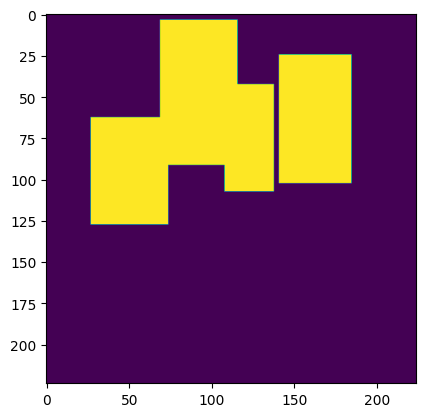

In [14]:
plt.imshow(Y_train[n]);

## 2. Model building
### A. Design a face mask detection model.
Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.

Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture.
### B. Design your own Dice Coefficient and Loss function. 
### C. Train and tune the model as required. 
### D. Evaluate and share insights on performance of the model. 


In [15]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

HEIGHT_CELLS = 28
WIDTH_CELLS = 28
BATCH_SIZE = 1

In [16]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [17]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [18]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output
    
    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_WIDTH, IMAGE_HEIGHT))(x)
    return Model(inputs = model.input, outputs = x)

In [19]:
model = create_model()

# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [20]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [21]:
# Unet is ready, hence Defining Dice Coefficient

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [22]:
# Define loss
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [23]:
from keras import backend as K
K.clear_session()

In [24]:
# Clear the backend session & set random seed
backend.clear_session()
import random
random.seed(42)
tf.random.set_seed(42)

In [25]:
import gc
gc.collect()

7788

In [26]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)

stop = EarlyStopping(monitor="loss", patience=5, mode="min")

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [28]:
# Fit the model
model.fit(X_train,Y_train,epochs = 50,verbose=1,batch_size=10,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/50

Epoch 1: loss improved from inf to 2.22140, saving model to model-2.22.h5
 1/40 [..............................] - ETA: 11:43 - loss: 2.2214 - dice_coefficient: 0.2275
Epoch 1: loss improved from 2.22140 to 2.18159, saving model to model-2.18.h5
 2/40 [>.............................] - ETA: 17s - loss: 2.1816 - dice_coefficient: 0.2300  
Epoch 1: loss improved from 2.18159 to 2.10469, saving model to model-2.10.h5
 3/40 [=>............................] - ETA: 16s - loss: 2.1047 - dice_coefficient: 0.2439
Epoch 1: loss improved from 2.10469 to 2.09248, saving model to model-2.09.h5
 4/40 [==>...........................] - ETA: 15s - loss: 2.0925 - dice_coefficient: 0.2464
Epoch 1: loss improved from 2.09248 to 2.01554, saving model to model-2.02.h5
 5/40 [==>...........................] - ETA: 15s - loss: 2.0155 - dice_coefficient: 0.2620
Epoch 1: loss did not improve from 2.01554
 6/40 [===>..........................] - ETA: 13s - loss: 2.1014 - dice_coefficient: 0.2449
Epo

In [29]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.9430 - dice_coefficient: 0.5386


[0.9429802298545837, 0.5386013984680176]

## 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

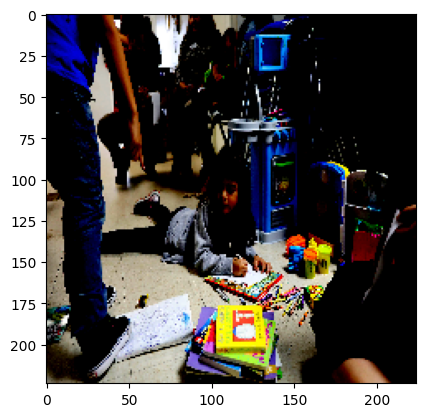

In [30]:
sample_image = X_test[3]

plt.imshow(sample_image);

In [31]:
# Reset the index of X_test numpy array
X_Test = X_test[np.arange(X_test.shape[0])]

# Reset the index of y_test numpy array
y_Test = Y_test[np.arange(Y_test.shape[0])]

In [32]:
y_pred = model.predict(X_Test)

1/1 [==============================] - 1s 947ms/step


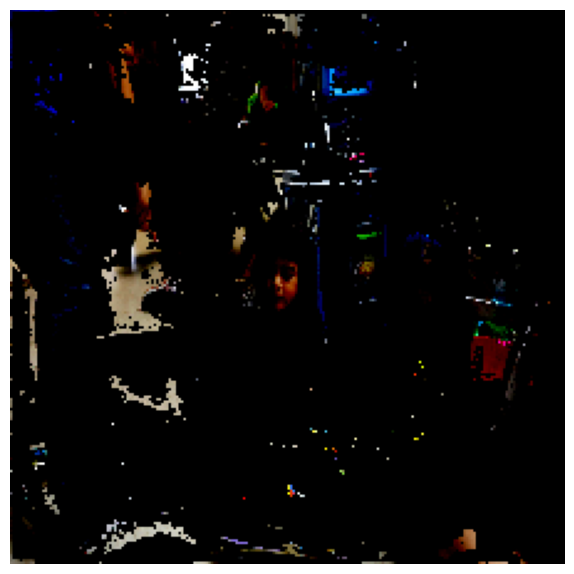

In [33]:
# For a sample image
n = 3
image = cv2.resize(X_Test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

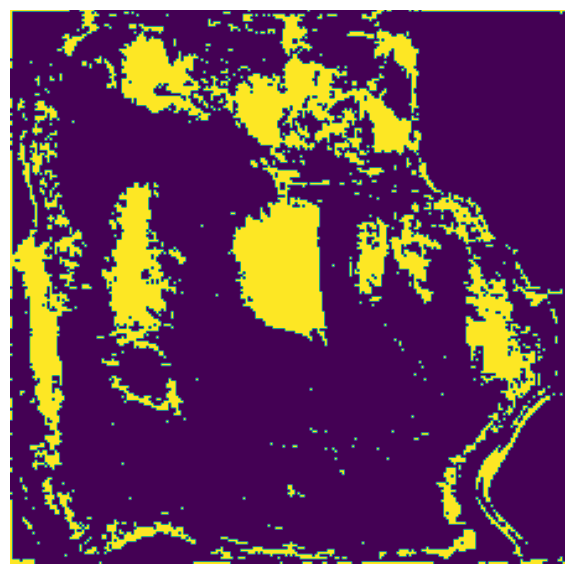

In [34]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

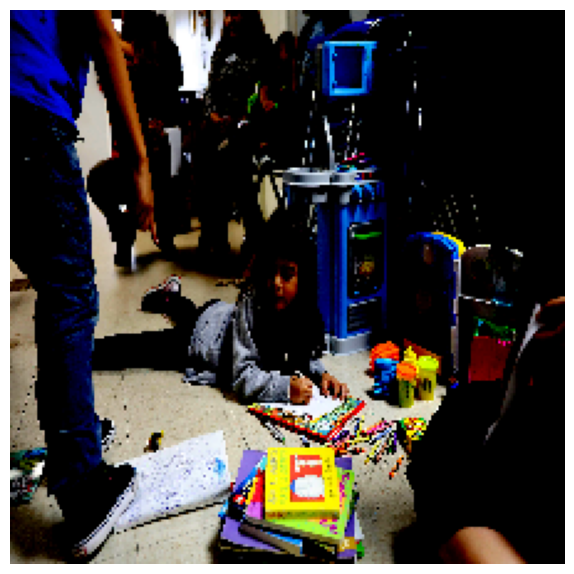

In [35]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_Test[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)